# ASSIGNMENT 1

- AML-2203 Advanced Python AI and ML Tools
- INSTRUCTOR: Vahid Hadavi, PhD, P.Eng
- CLASS: AML-2203
- STUDENTS: 
- Daniel Correia - C0789221
- Nihalkumar Jesadiya - C0793769
- Shah Razzakh Mohammed - C0794302
- Rohit Nanawati - C0796684

## DESCRIPTION

This assignment requires more individual learning than previous activities -you are encouraged to check out the <a href='https://pandas.pydata.org/pandas-docs/stable/'>pandas documentation</a> to find functions or methods you might not have used yet, or ask questions on <a href='http://stackoverflow.com/'>Stack Overflow</a> and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

<br>
<b>Definitions:</b>

* A quarter is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.  
* A recession is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth. 
* A recession bottom is the quarter within a recession which had the lowest GDP.
* A university town is a city which has a high percentage of university students compared to the total population of the city. 

<br>
<b>Hypothesis:</b><br>

University towns have their mean housing prices less effected by recessions. Perfome the following tasks: <br>

* Download the data and run a completed set of exploratory data analysis including best possible tasks on that. This may include but not limited to observing the shape, describe the data set, checking the missing values, drawing the profile of the data, checking the distribution type and data types and several other tasks.
* Run t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom.<p style="font-family:'Courier New'">(price_ratio=quarter_before_recession/recession_bottom)</p>


<br>
<b>The following data files are available for this assignment:</b><br>

* From the <a href='https://www.zillow.com/research/data/'>Zillow research data site</a> there is housing data for the United States. In particular the datafile for <a href='http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv'>all homes at a city level</a>, City_Zhvi_AllHomes.csv, has median home sale prices at a fine grained level.</li>
* From the Wikipedia page on college towns is a list of <a href='https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States'>university towns in the United States</a> which has been copy and pasted into the file university_towns.txt.
* From Bureau of Economic Analysis, US Department of Commerce, the <a href='http://www.bea.gov/national/index.htm#gdp'>GDP over time</a> of the United States in current dollars (use the chained value in 2009 dollars), in  quarterly intervals, in the file gdplev.xls. For this assignment, only look at GDP data from the first quarter of 2000 onward.

<br>
<p>Your report must include your Jupyter notebook including the detail of your code and proper markdowns and a pdf file explaining your approach and process, results and what your learned in this activity.</p>

## 1 - Download the data

### 1.1 - Import the libraries

In [ ]:
import pandas as pd
import re
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json
from scipy.stats import ttest_ind
from scipy import stats

### 1.2 - Download the data

In [ ]:
# Files originally downloaded from:
# https://www.kaggle.com/moezabid/zillow-all-homes-data?select=City_Zhvi_AllHomes.csv

university_towns = pd.read_csv("https://raw.githubusercontent.com/shahrazzkhmohammed/python-data-cleaning/master/Datasets/university_towns.txt", 
                               delimiter = "\t", header=None)
zillow_homes = pd.read_csv("https://raw.githubusercontent.com/shahrazzkhmohammed/python-data-cleaning/master/Datasets/City_Zhvi_AllHomes.csv")
gdp_annual = pd.read_excel("https://github.com/shahrazzkhmohammed/python-data-cleaning/blob/master/Datasets/gdplev.xls?raw=true",
                           header=5, usecols=[0, 1, 2])
gdp_quaterly = pd.read_excel("https://github.com/shahrazzkhmohammed/python-data-cleaning/blob/master/Datasets/gdplev.xls?raw=true",
                             header=5, usecols=[4, 5, 6])

In [ ]:
university_towns.head(2)

,0
0,Alabama[edit]
1,Auburn (Auburn University)[1]


In [ ]:
zillow_homes.head(2)

,RegionID,RegionName,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,...,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
0,6181,New York,NY,New York,Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,472100,474300,477600,481400,485100,488800,492600,495900,499500,503500,506400,509900,515700,520800,522200,522400,523800,526200,528400,529600,530800,532200,533800,536200,540600,545600,551400,557200,563000,568700,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,12447,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2,155000.0,154600.0,154400.0,154200.0,154100.0,154300.0,154300.0,154200.0,154800.0,155900.0,157000.0,157700.0,158200.0,158600.0,158800.0,158900.0,159100.0,159800.0,160700.0,161900.0,163400.0,165400.0,167000.0,168500.0,169900.0,171400.0,172900.0,174300.0,175800.0,177800.0,180100.0,182600.0,184400.0,185600.0,...,432700,440400,448100,455200,461900,467800,472300,475700,479400,484000,489400,494200,498100,501800,505600,509000,512600,516000,518900,521700,525100,528900,532400,535300,538200,541000,544000,547200,550600,554200,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100


In [ ]:
gdp_annual.head()

,Unnamed: 0,GDP in billions of current dollars,GDP in billions of chained 2009 dollars
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,1929.0,104.6,1056.6
3,1930.0,92.2,966.7
4,1931.0,77.4,904.8


In [ ]:
gdp_quaterly.head()

,Unnamed: 4,GDP in billions of current dollars.1,GDP in billions of chained 2009 dollars.1
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,1947q1,243.1,1934.5
3,1947q2,246.3,1932.3
4,1947q3,250.1,1930.3


In [ ]:
print(f'Shape of "university_towns.txt": {university_towns.shape}')
print(f'Shape of "City_Zhvi_AllHomes.csv: {zillow_homes.shape}')
print(f'Shape of "gdplev.xls" (Annual columns): {gdp_annual.shape}')
print(f'Shape of "gdplev.xls" (Quarterly columns): {gdp_quaterly.shape}')

Shape of "university_towns.txt": (567, 1)
Shape of "City_Zhvi_AllHomes.csv: (10730, 251)
Shape of "gdplev.xls" (Annual columns): (280, 3)
Shape of "gdplev.xls" (Quarterly columns): (280, 3)


Original files vs. dataframes:
* university_towns.txt: The States are listed as Universities because the file was created with only one column
* City_Zhvi_AllHomes.csv: There is no problem in this dataframe (at least for now)
* gdplev.xls" (annual): The dataframe contains much more rows than the original file. This hapens due to the size of the other table present in this file. Also, the first two rows are empty.
* gdplev.xls" (quaterly): Besides the two first rows empty, there is no problem in this dataset. The first column has no title (as in the original file.

### 1.3 - Initial adjustments on the dataframes

#### university_towns.txt

In [ ]:
pd.set_option('display.max_colwidth', -1)
def extract_universities(df: pd.DataFrame) -> pd.DataFrame:
  state = ''
  values = []
  for item in df[0]:
    if item.endswith('[edit]'):
      state = item[:-6]
    else:
      values.append((state,item))
  
  return pd.DataFrame(values)

universities = extract_universities(university_towns)
universities.columns = ['State','University']

universities['University'] = universities['University'].apply(
    lambda x: re.sub('\[[0-9]\]', '', x))

universities.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,State,University
0,Alabama,Auburn (Auburn University)
1,Alabama,Florence (University of North Alabama)
2,Alabama,Jacksonville (Jacksonville State University)
3,Alabama,Livingston (University of West Alabama)
4,Alabama,Montevallo (University of Montevallo)
5,Alabama,Troy (Troy University)
6,Alabama,"Tuscaloosa (University of Alabama, Stillman College, Shelton State)"
7,Alabama,Tuskegee (Tuskegee University)
8,Alaska,Fairbanks (University of Alaska Fairbanks)
9,Arizona,Flagstaff (Northern Arizona University)


In [ ]:
universities.groupby(['State','University']).count()

Empty DataFrame
Columns: []
Index: [(Alabama, Auburn (Auburn University)), (Alabama, Florence (University of North Alabama)), (Alabama, Jacksonville (Jacksonville State University)), (Alabama, Livingston (University of West Alabama)), (Alabama, Montevallo (University of Montevallo)), (Alabama, Troy (Troy University)), (Alabama, Tuscaloosa (University of Alabama, Stillman College, Shelton State)), (Alabama, Tuskegee (Tuskegee University)), (Alaska, Fairbanks (University of Alaska Fairbanks)), (Arizona, Flagstaff (Northern Arizona University)), (Arizona, Tempe (Arizona State University)), (Arizona, Tucson (University of Arizona)), (Arkansas, Arkadelphia (Henderson State University, Ouachita Baptist University)), (Arkansas, Conway (Central Baptist College, Hendrix College, University of Central Arkansas)), (Arkansas, Fayetteville (University of Arkansas)), (Arkansas, Jonesboro (Arkansas State University)), (Arkansas, Magnolia (Southern Arkansas University)), (Arkansas, Monticello (University of Arkansas at Monticello)), (Arkansas, Russellville (Arkansas Tech University)), (Arkansas, Searcy (Harding University)), (California, Angwin (Pacific Union College)), (California, Arcata (Humboldt State University)), (California, Berkeley (University of California, Berkeley)), (California, Chico (California State University, Chico)), (California, Claremont (Claremont McKenna College, Pomona College, Harvey Mudd College, Scripps College, Pitzer College, Keck Graduate Institute, Claremont Graduate University)), (California, Cotati (California State University, Sonoma)), (California, Davis (University of California, Davis)), (California, Irvine (University of California, Irvine)), (California, Isla Vista (University of California, Santa Barbara)), (California, Merced (University of California, Merced)), (California, Orange (Chapman University)), (California, Palo Alto (Stanford University)), (California, Pomona (Cal Poly Pomona, WesternU)[10][11] and formerly Pomona College), (California, Redlands (University of Redlands)), (California, Riverside (University of California, Riverside, California Baptist University, La Sierra University)), (California, Sacramento (California State University, Sacramento)), (California, San Diego (University of California, San Diego, San Diego State University)), (California, San Luis Obispo (California Polytechnic State University)), (California, Santa Barbara (Fielding Graduate University, Santa Barbara City College, University of California, Santa Barbara, Westmont College)), (California, Santa Cruz (University of California, Santa Cruz)), (California, Turlock (California State University, Stanislaus)), (California, University District, San Bernardino (California State University, San Bernardino, American Sports University)), (California, University Park, Los Angeles (University of Southern California)), (California, Westwood, Los Angeles (University of California, Los Angeles)), (California, Whittier (Whittier CollegeRio Hondo College)), (Colorado, Alamosa (Adams State College)), (Colorado, Boulder (University of Colorado at Boulder)[12]), (Colorado, Durango (Fort Lewis College)), (Colorado, Fort Collins (Colorado State University)[13]), (Colorado, Golden (Colorado School of Mines)), (Colorado, Grand Junction (Colorado Mesa University)), (Colorado, Greeley (University of Northern Colorado)), (Colorado, Gunnison (Western State College)), (Colorado, Pueblo, Colorado (Colorado State University-Pueblo)), (Connecticut, Fairfield (Fairfield University, Sacred Heart University)), (Connecticut, Middletown (Wesleyan University)), (Connecticut, New Britain (Central Connecticut State University)), (Connecticut, New Haven (Yale University, University of New Haven, Southern Connecticut State University, Albertus Magnus College, Quinnipiac University)[14]), (Connecticut, New London (Connecticut College, US Coast Guard Academy, Mitchell College)), (Connecticut, Storrs (University of Connecticut)), (Connecticut, Willimantic 

In [ ]:
universities.groupby('State').count()

,University
State,
Alabama,8
Alaska,1
Arizona,3
Arkansas,8
California,25
Colorado,9
Connecticut,7
Delaware,2
Florida,12


#### gdplev.xls (annual)

In [ ]:
# Number of missing values
gdp_annual.isnull().sum()

Unnamed: 0                                 193
GDP in billions of current dollars         193
GDP in billions of chained 2009 dollars    193
dtype: int64

In [ ]:
#Dropping the rows with all columns missing
gdp_annual.dropna(how='all',inplace=True)

#Number of missing values after the drop
gdp_annual.isnull().sum()

Unnamed: 0                                 0
GDP in billions of current dollars         0
GDP in billions of chained 2009 dollars    0
dtype: int64

In [ ]:
gdp_annual.shape

(87, 3)

Now the gpd_annual dataframe matches the original file

#### gdplev.xls (quaterly)

In [ ]:
# Number of missing values
gdp_quaterly.isnull().sum()

Unnamed: 4                                   2
GDP in billions of current dollars.1         2
GDP in billions of chained 2009 dollars.1    2
dtype: int64

In [ ]:
# Dropping the rows with all columns missing
gdp_quaterly.dropna(how='all',inplace=True)

# Number of missing values after the drop
gdp_quaterly.isnull().sum()

Unnamed: 4                                   0
GDP in billions of current dollars.1         0
GDP in billions of chained 2009 dollars.1    0
dtype: int64

In [ ]:
gdp_quaterly.shape

(278, 3)

In [ ]:
# Rename the first column
gdp_quaterly.rename(columns ={'$a':'a'},inplace = True)
gdp_quaterly.head(3)

,Unnamed: 4,GDP in billions of current dollars.1,GDP in billions of chained 2009 dollars.1
2,1947q1,243.1,1934.5
3,1947q2,246.3,1932.3
4,1947q3,250.1,1930.3


## 2 - Exploratory data analysis

#### 2.1 - Shape of the dataframes

In [ ]:
print(f'Shape of "university_towns.txt": {universities.shape}')
print(f'Shape of "City_Zhvi_AllHomes.csv": {zillow_homes.shape}')
print(f'Shape of "gdplev.xls" (Annual columns): {gdp_annual.shape}')
print(f'Shape of "gdplev.xls" (Quaterly columns):{gdp_quaterly.shape}')

Shape of "university_towns.txt": (517, 2)
Shape of "City_Zhvi_AllHomes.csv": (10730, 251)
Shape of "gdplev.xls" (Annual columns): (87, 3)
Shape of "gdplev.xls" (Quaterly columns):(278, 3)


#### 2.2 - Describe each dataframe

university_towns.txt

In [ ]:
# university_towns.txt
universities.describe()

,State,University
count,517,517
unique,50,517
top,Pennsylvania,Annville (Lebanon Valley College)
freq,43,1


In [ ]:
universities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   State       517 non-null    object
 1   University  517 non-null    object
dtypes: object(2)
memory usage: 8.2+ KB


In [ ]:
universities_count = universities.groupby('State').count().iloc[:].values

print(f'Minimum value in the number of universities: {universities_count.min()}')
print(f'Maximum value in the number of universities: {universities_count.max()}')
print(f'Variance in the number of universities: {universities_count.var()}')
print(f'Mean value in the number of universities: {universities_count.mean()}')

Minimum value in the number of universities: 1
Maximum value in the number of universities: 43
Variance in the number of universities: 64.5844
Mean value in the number of universities: 10.34


City_Zhvi_AllHomes.csv

In [ ]:
# City_Zhvi_AllHomes.csv
zillow_homes.describe()

,RegionID,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,...,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
count,10730.000000,10730.000000,8.083000e+03,8.179000e+03,8.218000e+03,8.221000e+03,8.229000e+03,8.229000e+03,8.229000e+03,8.235000e+03,8.235000e+03,8.266000e+03,8.773000e+03,8.815000e+03,8.816000e+03,8.816000e+03,8.818000e+03,8.818000e+03,8.938000e+03,8.942000e+03,8.945000e+03,8.947000e+03,8.949000e+03,8.965000e+03,9.100000e+03,9.100000e+03,9.077000e+03,8.942000e+03,8.943000e+03,9.175000e+03,9.208000e+03,9.209000e+03,9.222000e+03,9.253000e+03,9.253000e+03,9.253000e+03,9.286000e+03,9.286000e+03,9.286000e+03,9.299000e+03,...,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04,1.073000e+04
mean,87338.218080,5365.500000,1.203738e+05,1.204542e+05,1.203388e+05,1.204008e+05,1.204700e+05,1.205682e+05,1.207127e+05,1.210040e+05,1.213067e+05,1.217440e+05,1.221581e+05,1.228311e+05,1.231952e+05,1.235492e+05,1.239244e+05,1.243571e+05,1.246037e+05,1.251105e+05,1.255970e+05,1.261762e+05,1.268227e+05,1.275190e+05,1.281595e+05,1.288488e+05,1.289552e+05,1.286231e+05,1.289821e+05,1.308627e+05,1.313176e+05,1.318279e+05,1.326436e+05,1.335799e+05,1.342554e+05,1.350049e+05,1.356141e+05,1.364139e+05,1.372001e+05,1.380001e+05,...,2.078913e+05,2.092393e+05,2.105938e+05,2.118851e+05,2.130728e+05,2.141322e+05,2.151157e+05,2.159730e+05,2.167167e+05,2.174820e+05,2.183508e+05,2.193117e+05,2.203436e+05,2.213429e+05,2.222412e+05,2.231461e+05,2.240232e+05,2.248488e+05,2.256713e+05,2.263195e+05,2.268571e+05,2.276267e+05,2.286248e+05,2.295357e+05,2.304256e+05,2.313705e+05,2.323251e+05,2.333054e+05,2.343365e+05,2.353763e+05,2.363926e+05,2.372042e+05,2.378533e+05,2.386053e+05,2.395900e+05,2.405300e+05,2.413038e+05,2.419801e+05,2.428608e+05,2.436931e+05
std,128121.389608,3097.628528,7.835705e+04,7.790580e+04,7.785422e+04,7.795274e+04,7.795952e+04,7.802532e+04,7.816369e+04,7.835491e+04,7.858560e+04,7.900233e+04,8.224729e+04,8.268524e+04,8.304765e+04,8.335811e+04,8.367327e+04,8.412323e+04,8.501208e+04,8.549245e+04,8.594872e+04,8.648052e+04,8.712777e+04,8.786693e+04,8.854894e+04,8.919718e+04,8.936801e+04,8.829316e+04,8.881030e+04,9.115163e+04,9.170009e+04,9.231440e+04,9.363743e+04,9.457343e+04,9.530065e+04,9.604829e+04,9.671101e+04,9.750570e+04,9.842512e+04,9.946678e+04,...,1.974985e+05,1.996895e+05,2.017562e+05,2.036668e+05,2.052986e+05,2.066364e+05,2.079752e+05,2.092130e+05,2.103503e+05,2.115836e+05,2.130530e+05,2.144234e+05,2.155211e+05,2.165174e+05,2.177367e+05,2.191618e+05,2.205518e+05,2.219142e+05,2.233961e+05,2.246370e+05,2.259766e+05,2.279990e+05,2.304076e+05,2.324448e+05,2.340784e+05,2.353656e+05,2.366140e+05,2.380208e+05,2.394723e+05,2.409674e+05,2.423569e+05,2.432497e+05,2.441329e+05,2.451509e+05,2.461725e+05,2.467904e+05,2.471556e+05,2.473850e+05,2.477199e+05,2.479585e+05
min,3304.000000,1.000000,2.400000e+04,2.430000e+04,2.420000e+04,2.370000e+04,2.350000e+04,2.340000e+04,2.380000e+04,2.430000e+04,2.440000e+04,2.450000e+04,2.410000e+04,2.470000e+04,2.440000e+04,2.360000e+04,

In [ ]:
zillow_homes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10730 entries, 0 to 10729
Columns: 251 entries, RegionID to 2016-08
dtypes: float64(201), int64(46), object(4)
memory usage: 20.5+ MB


gdplev.xls

In [ ]:
# gdplev.xls
gdp_annual.describe()

,Unnamed: 0,GDP in billions of current dollars,GDP in billions of chained 2009 dollars
count,87.000000,87.000000,87.000000
mean,1972.000000,4304.554023,6412.983908
std,25.258662,5341.972399,4795.360368
min,1929.000000,57.200000,778.300000
25%,1950.500000,323.750000,2299.700000
50%,1972.000000,1282.400000,5134.300000
75%,1993.500000,7093.750000,9713.200000
max,2015.000000,18036.600000,16397.200000


In [ ]:
gdp_annual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 2 to 88
Data columns (total 3 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               87 non-null     float64
 1   GDP in billions of current dollars       87 non-null     float64
 2   GDP in billions of chained 2009 dollars  87 non-null     float64
dtypes: float64(3)
memory usage: 2.7 KB


In [ ]:
# gdplev.xls
gdp_quaterly.describe()

,GDP in billions of current dollars.1,GDP in billions of chained 2009 dollars.1
count,278.000000,278.000000
mean,5489.302518,7805.390647
std,5560.409008,4533.487858
min,243.100000,1930.300000
25%,683.800000,3729.025000
50%,3267.500000,6517.550000
75%,9416.750000,11841.200000
max,18450.100000,16583.100000


In [ ]:
gdp_quaterly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278 entries, 2 to 279
Data columns (total 3 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Unnamed: 4                                 278 non-null    object 
 1   GDP in billions of current dollars.1       278 non-null    float64
 2   GDP in billions of chained 2009 dollars.1  278 non-null    float64
dtypes: float64(2), object(1)
memory usage: 8.7+ KB


#### 2.3 - Check missing values

In [ ]:
# Checking the total value of missing values in each dataframe
print(f'Total of missing values in universities: {universities.isna().sum().sum()}')
print(f'Total of missing values in zillow_homes": {zillow_homes.isna().sum().sum()}')
print(f'Total of missing values in gdp_annual": {gdp_annual.isna().sum().sum()}')
print(f'Total of missing values in gdp_quaterly": {gdp_quaterly.isna().sum().sum()}')

Total of missing values in universities: 0
Total of missing values in zillow_homes": 216300
Total of missing values in gdp_annual": 0
Total of missing values in gdp_quaterly": 0


After the initial adjustment of the dataframes, the only one with missing values is the 'zillow_homes'

In [ ]:
# zillow_homes missing values:
zillow_missing_values = []
for column in zillow_homes.columns:
  if zillow_homes[column].isna().sum() > 0:
    zillow_missing_values.append((column, zillow_homes[column].isna().sum()))

In [ ]:
zillow_missing_values_df = pd.DataFrame(zillow_missing_values)
zillow_missing_values_df.head(10)

,0,1
0,Metro,471
1,1996-04,2647
2,1996-05,2551
3,1996-06,2512
4,1996-07,2509
5,1996-08,2501
6,1996-09,2501
7,1996-10,2501
8,1996-11,2495
9,1996-12,2495


In [ ]:
# Drop the first row
zillow_missing_values_df.drop(index=0, inplace=True)
zillow_missing_values_df.head(2)

,0,1
1,1996-04,2647
2,1996-05,2551


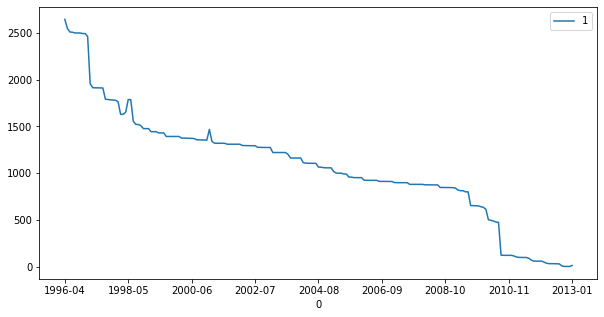

In [ ]:
zillow_missing_values_df.plot(x=0, y=1,figsize=(10,5))

Most of the missing values are related to old dates, probably because part of the residences did not exist in that period.

In [ ]:
# The 'Metro' column is not going to be used, so it will be dropped
del zillow_homes['Metro']
zillow_homes.iloc[0:3, 0:8]

,RegionID,RegionName,State,CountyName,SizeRank,1996-04,1996-05,1996-06
0,6181,New York,NY,Queens,1,NaN,NaN,NaN
1,12447,Los Angeles,CA,Los Angeles,2,155000.0,154600.0,154400.0
2,17426,Chicago,IL,Cook,3,109700.0,109400.0,109300.0


The missing values from the columns with median price information will be dealt according to the need in the further steps

#### 2.4 - Drawing the profile of the data

##### university_towns.txt

In [ ]:
# Number of universities per state
fig = px.bar(x=universities.groupby('State').count().iloc[:].index, 
             y=universities.groupby('State').count().iloc[:].values, 
             title="Universities per State")

fig.update_yaxes(title='Universities')
fig.update_xaxes(title='States')
fig.show()

In [ ]:
# Number of universities per state
fig = px.pie(values=universities.groupby('State').count().iloc[:].values, 
             names=universities.groupby('State').count().iloc[:].index, 
             title='Universities per State', width=1_200, height= 1_000)
fig.update_traces(textposition='inside', textinfo='percent+label')

fig.show()

In [ ]:
fig = px.box(y=
             [x[0] for x in universities.groupby('State').count().iloc[:].values.tolist()],
             width=300, height=400)
fig.update_xaxes(title='Universities')
fig.update_yaxes(title='n')
fig.show()

In [ ]:
x = [x[0] for x in universities.groupby('State').count().iloc[:].values.tolist()]

fig = ff.create_distplot([x], ['Number of universities'])
fig.show()

In [ ]:
state_code ="""
ALABAMA	AL
ALASKA	AK
AMERICAN SAMOA	AS
ARIZONA	AZ
ARKANSAS	AR
CALIFORNIA	CA
COLORADO	CO
CONNECTICUT	CT
DELAWARE	DE
DISTRICT OF COLUMBIA	DC
FLORIDA	FL
GEORGIA	GA
GUAM	GU
HAWAII	HI
IDAHO	ID
ILLINOIS	IL
INDIANA	IN
IOWA	IA
KANSAS	KS
KENTUCKY	KY
LOUISIANA	LA
MAINE	ME
MARYLAND	MD
MASSACHUSETTS	MA
MICHIGAN	MI
MINNESOTA	MN
MISSISSIPPI	MS
MISSOURI	MO
MONTANA	MT
NEBRASKA	NE
NEVADA	NV
NEW HAMPSHIRE	NH
NEW JERSEY	NJ
NEW MEXICO	NM
NEW YORK	NY
NORTH CAROLINA	NC
NORTH DAKOTA	ND
NORTHERN MARIANA IS	MP
OHIO	OH
OKLAHOMA	OK
OREGON	OR
PENNSYLVANIA	PA
PUERTO RICO	PR
RHODE ISLAND	RI
SOUTH CAROLINA	SC
SOUTH DAKOTA	SD
TENNESSEE	TN
TEXAS	TX
UTAH	UT
VERMONT	VT
VIRGINIA	VA
VIRGIN ISLANDS	VI
WASHINGTON	WA
WEST VIRGINIA	WV
WISCONSIN	WI
WYOMING	WY
"""
# Downloaded from: https://www.ssa.gov/international/coc-docs/states.html

# List like: 'ALABAMA\tAL'
state_code = state_code.split('\n')

# Dictionary like: 'ALABAMA': 'AL'
state_code = dict([(i[0:-3], i[-2:]) for i in state_code])

universities['code'] = universities['State'].apply(lambda x: state_code[x.upper()])
universities.head(3)

,State,University,code
0,Alabama,Auburn (Auburn University),AL
1,Alabama,Florence (University of North Alabama),AL
2,Alabama,Jacksonville (Jacksonville State University),AL


For some reason the codes are incorrect on USA map

In [ ]:
aux = pd.DataFrame({'Code': universities.groupby('code').count().index, 
                    'State': universities.groupby('State').count().index, 
                    'Count': [x[0] for x in universities.groupby(['State', 'code']).count().values.tolist()]
                    })

fig = px.choropleth(data_frame=aux,
                    locations='Code', 
                    locationmode="USA-states",
                    color='Count', 
                    hover_name='State',
                    scope="usa", width=1_000, height=500, title='Universities per State')
fig.show()

##### City_Zhvi_AllHomes.csv

In [ ]:
# First 8 columns
zillow_homes.iloc[0:2, 0:8]

,RegionID,RegionName,State,CountyName,SizeRank,1996-04,1996-05,1996-06
0,6181,New York,NY,Queens,1,NaN,NaN,NaN
1,12447,Los Angeles,CA,Los Angeles,2,155000.0,154600.0,154400.0


In [ ]:
# Last 3 columns
zillow_homes.iloc[0:2, -3:]

,2016-06,2016-07,2016-08
0,590200,588000,586400
1,580600,583000,585100


In [ ]:
print(f'zillow_homes shape[0]: {zillow_homes.shape[0]}')
print(f"zillow_homes['RegionID'].nunique(): {zillow_homes['RegionID'].nunique()}")
print(f"zillow_homes['RegionName'].nunique(): {zillow_homes['RegionName'].nunique()}")

zillow_homes shape[0]: 10730
zillow_homes['RegionID'].nunique(): 10730
zillow_homes['RegionName'].nunique(): 8258


Region ID and Region Name are not equivalent

In [ ]:
# Regions per State
fig = px.bar(x=zillow_homes.groupby('State').count().iloc[:].index, 
             y=[x[0] for x in zillow_homes.groupby('State').count().iloc[:].values.tolist()], 
             title="Regions per State")

fig.update_yaxes(title='Regions')
fig.update_xaxes(title='States')
fig.show()

In [ ]:
# Regions per State
aux = pd.DataFrame({'Code': zillow_homes.groupby('State').count().index, 
                    'Count': [x[0] for x in zillow_homes.groupby(['State']).count().values.tolist()]
                    })

fig = px.choropleth(data_frame=aux,
                    locations='Code', 
                    locationmode="USA-states",
                    color='Count', 
                    scope="usa", width=1_000, height=500, title='Regions per State')
fig.show()

The map of USA (extracted from Wikipedia)
<br><br>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Map_of_USA_States_with_names_white.svg/1920px-Map_of_USA_States_with_names_white.svg.png" alt="USA States">

In [ ]:
zillow_homes[zillow_homes['State'] == 'SD'].iloc[:, 0:3]

,RegionID,RegionName,State


The dataset does not contain data about South Dakota!

In [ ]:
zillow_df2 = zillow_homes.drop(['RegionID', 'SizeRank'], 
                        axis=1).groupby('State').mean()

In [ ]:
zillow_df2.head(5)

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,...,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181300.000000,182000.000000,182800.000000,183500.000000,183900.000000,183800.000000,182800.000000,182800.000000,183600.000000,183300.000000,182500.000000,177671.428571,174685.714286,172428.571429,171100.000000,170457.142857,169857.142857,169071.428571,168385.714286,168642.857143,169742.857143,170971.428571,172014.285714,...,218742.857143,219585.714286,220528.571429,220678.571429,220264.285714,219914.285714,219771.428571,220085.714286,221221.428571,222150.000000,222600.000000,223014.285714,223335.714286,223685.714286,224228.571429,224192.857143,223492.857143,223014.285714,223371.428571,224221.428571,225028.571429,225657.142857,226314.285714,226692.857143,226764.285714,226871.428571,227378.571429,227750.000000,227692.857143,227700.000000,228257.142857,229300.000000,230314.285714,231085.714286,231907.142857,233685.714286,235300.000000,235778.571429,235542.857143,235278.571429
AL,93837.634409,93509.677419,93595.698925,93811.827957,93819.354839,93730.107527,93792.473118,94053.763441,94405.376344,94694.623656,94956.989247,95387.096774,95984.946237,96466.666667,96853.763441,97246.236559,97473.684211,97856.842105,98278.947368,98708.421053,99230.526316,99966.315789,100005.154639,100437.113402,100624.742268,100738.144330,100960.824742,101425.773196,101997.938144,102489.690722,102914.432990,103275.257732,103605.154639,103871.134021,103856.122449,104180.612245,104645.918367,105081.632653,105285.714286,105280.612245,...,128804.511278,129030.827068,129224.060150,129457.894737,129690.225564,129959.398496,130296.992481,130545.864662,130618.045113,130730.827068,130844.360902,130953.383459,131229.323308,131538.345865,131684.210526,132063.909774,132627.067669,133157.142857,133611.278195,133923.308271,134119.548872,134453.383459,134924.060150,135395.488722,135934.586466,136512.781955,136939.097744,137131.578947,137481.954887,137991.729323,138388.721805,138566.165414,138562.406015,138529.323308,138667.669173,138862.406015,138938.345865,138971.428571,139130.075188,139333.082707
AR,75444.594595,75895.945946,76277.027027,76531.081081,76733.783784,76877.027027,77031.081081,77251.351351,77455.405405,77614.864865,78224.000000,78756.000000,79368.000000,79814.666667,80114.666667,80322.666667,80492.000000,80696.000000,80953.333333,81200.000000,81453.333333,81624.000000,81851.315789,82003.947368,82052.631579,81931.578947,81892.105263,81981.578947,82113.157895,82130.263158,82144.736842,82264.473684,82565.789474,82885.526316,83115.789474,83263.157895,83314.473684,83278.947368,83344.736842,83526.315789,...,124100.000000,124357.894737,124542.105263,124680.263158,124830.263158,125130.263158,125617.105263,125842.105263,125722.368421,125638.157895,125634.210526,125736.842105,125957.894737,126168.421053,126357.894737,126619.736842,126927.631579,127418.421053,127969.736842,128221.052632,128281.578947,128363.157895,128427.631579,128486.842105,128675.000000,128943.421053,129167.105263,129494.736842,130052.631579,130671.052632,131155.263158,131610.526316,132030.263158,132390.789474,132778.947368,133260.526316,133761.842105,134382.894737,135182.894737,135921.052632
AZ,106306.796117,106407.766990,106487.378641,106555.339806,106652.427184,106718.446602,106827.184466,106971.844660,1072

In [ ]:
zillow_homes

,RegionID,RegionName,State,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,...,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
0,6181,New York,NY,Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,472100,474300,477600,481400,485100,488800,492600,495900,499500,503500,506400,509900,515700,520800,522200,522400,523800,526200,528400,529600,530800,532200,533800,536200,540600,545600,551400,557200,563000,568700,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,12447,Los Angeles,CA,Los Angeles,2,155000.0,154600.0,154400.0,154200.0,154100.0,154300.0,154300.0,154200.0,154800.0,155900.0,157000.0,157700.0,158200.0,158600.0,158800.0,158900.0,159100.0,159800.0,160700.0,161900.0,163400.0,165400.0,167000.0,168500.0,169900.0,171400.0,172900.0,174300.0,175800.0,177800.0,180100.0,182600.0,184400.0,185600.0,186900.0,...,432700,440400,448100,455200,461900,467800,472300,475700,479400,484000,489400,494200,498100,501800,505600,509000,512600,516000,518900,521700,525100,528900,532400,535300,538200,541000,544000,547200,550600,554200,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
2,17426,Chicago,IL,Cook,3,109700.0,109400.0,109300.0,109300.0,109100.0,109000.0,109000.0,109600.0,110200.0,110800.0,111300.0,111700.0,112200.0,112300.0,112100.0,112200.0,113000.0,113700.0,114200.0,114800.0,115500.0,116200.0,117100.0,117600.0,117800.0,118300.0,119200.0,120000.0,120600.0,121500.0,122300.0,122700.0,122900.0,123300.0,123700.0,...,172400,175100,178200,181000,183200,184600,185800,187200,189100,191100,192500,192600,192400,192900,193900,195600,197800,200100,201700,202000,201200,200500,201500,204000,206500,207600,207700,208100,209100,209000,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
3,13271,Philadelphia,PA,Philadelphia,4,50000.0,49900.0,49600.0,49400.0,49400.0,49300.0,49300.0,49400.0,49700.0,49600.0,49500.0,49700.0,49800.0,49700.0,49700.0,49800.0,49700.0,49700.0,49800.0,49900.0,49900.0,50000.0,50300.0,50600.0,50800.0,50800.0,50800.0,50800.0,50700.0,50500.0,50500.0,50700.0,50700.0,50800.0,50900.0,...,111800,111200,111000,110900,111100,111800,112700,112900,113100,113900,114200,113600,113500,114100,114900,115500,115500,115400,115600,116000,116100,116100,116400,117000,117900,119000,120100,121300,122300,122700,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
4,40326,Phoenix,AZ,Maricopa,5,87200.0,87700.0,88200.0,88400.0,88500.0,88900.0,89400.0,89700.0,90100.0,90700.0,91400.0,91700.0,91800.0,92000.0,92300.0,92600.0,93000.0,93400.0,94000.0,94600.0,95300.0,96100.0,96800.0,97300.0,97700.0,98400.0,99200.0,100100.0,100500.0,100700.0,100900.0,101700.0,102600.0,103400.0,103900.0,...,144700,147400,150500,153600,156100,158100,160000,161600,162700,163300,163700,164100,164200,164500,164700,165200,166200,167200,168400,169900,171000,171500,172100,172900,174100,175500,177100,179100,181000,182400,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,398292,Town of Wrightstown,WI,Brown,10726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
# Mean value per Period per State
zillow_df2 = zillow_homes.drop(['RegionID', 'SizeRank'], 
                        axis=1).groupby('State').mean()

# Values for each State
values = []
for colum in zillow_df2.columns.values:
    values += zillow_df2[colum].tolist()

# States
states = zillow_df2.index.tolist()

# Periods
period = [zillow_df2.columns.to_list()][0]

# Number of periods
n_periods = len(period)

# Period repeated -> T1, T1, T1 ...x50, T2, T2, T2 ...x50 ...
period = ' '.join([(i + ' ') * 50 for i in period]).split()

# States repeated -> S1, S2, S3 ...x50 ... S1, S2
states = states * n_periods

zillow_df2 = pd.DataFrame(data={'Period': period,
                          'State': states,
                          'Value': values})

fig = px.scatter(zillow_df2, x="Period", y="Value", color='State', 
                 width=1_200, height=800,
                 title='Mean value per Period per State')

fig.update_xaxes(title='Period')
fig.update_yaxes(title='Mean Value')

fig.show()

In [ ]:
# Median home sale prices per RegionId (boxplot)
fig = px.box(y=zillow_df2['Value'], x=zillow_df2['State'],
             width=1_400, height=800, 
             title='Boxplots for each State')

fig.update_xaxes(title='States')
fig.update_yaxes(title='Values')

fig.show()

##### gdplev.xls

###### gdplev.xls (annual)

In [ ]:
gdp_annual.head(3)

,Unnamed: 0,GDP in billions of current dollars,GDP in billions of chained 2009 dollars
2,1929.0,104.6,1056.6
3,1930.0,92.2,966.7
4,1931.0,77.4,904.8


In [ ]:
# Rename the columns
gdp_annual.columns = ['year', 'GDP in $B.', 'GDP in $B. - chained 2009']

# Change the type of 'year' feature
gdp_annual['year'] = gdp_annual['year'].astype('int')

# Reset the index
gdp_annual.reset_index(inplace=True, drop=True)

gdp_annual.head()

,year,GDP in $B.,GDP in $B. - chained 2009
0,1929,104.6,1056.6
1,1930,92.2,966.7
2,1931,77.4,904.8
3,1932,59.5,788.2
4,1933,57.2,778.3


In [ ]:
n_lines = gdp_annual.shape[0]

current_txt = ['GDP in $B.'] * n_lines
current = gdp_annual['GDP in $B.'].values.tolist()

chained_txt = ['GDP in $B. - chained 2009'] * n_lines
chained = gdp_annual['GDP in $B. - chained 2009'].values.tolist()

txt = current_txt + chained_txt
values = current + chained

year = gdp_annual['year'].values.tolist() * 2 

gdp_annual_aux_df = pd.DataFrame({'year': year, 'type': txt, 
                                  'values': values})
gdp_annual_aux_df.head()

,year,type,values
0,1929,GDP in $B.,104.6
1,1930,GDP in $B.,92.2
2,1931,GDP in $B.,77.4
3,1932,GDP in $B.,59.5
4,1933,GDP in $B.,57.2


In [ ]:
fig = px.line(gdp_annual_aux_df, x="year", y="values", 
              color='type', title='GDP', width=1_200,
              labels={'values': 'Amount'})

fig.update_traces(mode='markers+lines')

fig.update_xaxes(title='Years')
fig.update_yaxes(title='Billions of dollar')

fig.show()

In [ ]:
fig = px.histogram(gdp_annual_aux_df, x="values", color='type',
                   marginal="box", # or violin, rug
                   width=1_200,
                   labels={'values': 'Amount'}, 
                   opacity=0.8)
fig.show()

In [ ]:
fig = px.box(gdp_annual_aux_df, x="type", y="values",
             width=1_200)
fig.show()

###### gdplev.xls (quaterly)

In [ ]:
gdp_quaterly.head()

,Unnamed: 4,GDP in billions of current dollars.1,GDP in billions of chained 2009 dollars.1
2,1947q1,243.1,1934.5
3,1947q2,246.3,1932.3
4,1947q3,250.1,1930.3
5,1947q4,260.3,1960.7
6,1948q1,266.2,1989.5


In [ ]:
# Rename the columns
gdp_quaterly.columns = ['period', 'GDP in $B.', 'GDP in $B. - chained 2009']

# Reset the index
gdp_quaterly.reset_index(inplace=True, drop=True)

gdp_quaterly.head()

,period,GDP in $B.,GDP in $B. - chained 2009
0,1947q1,243.1,1934.5
1,1947q2,246.3,1932.3
2,1947q3,250.1,1930.3
3,1947q4,260.3,1960.7
4,1948q1,266.2,1989.5


In [ ]:
# Extract year and quarter
gdp_quaterly['year'] = gdp_quaterly['period'].apply(lambda x: int(x[:-2]))
gdp_quaterly['quarter'] = gdp_quaterly['period'].apply(lambda x: int(x[-1]))
gdp_quaterly.head()

,period,GDP in $B.,GDP in $B. - chained 2009,year,quarter
0,1947q1,243.1,1934.5,1947,1
1,1947q2,246.3,1932.3,1947,2
2,1947q3,250.1,1930.3,1947,3
3,1947q4,260.3,1960.7,1947,4
4,1948q1,266.2,1989.5,1948,1


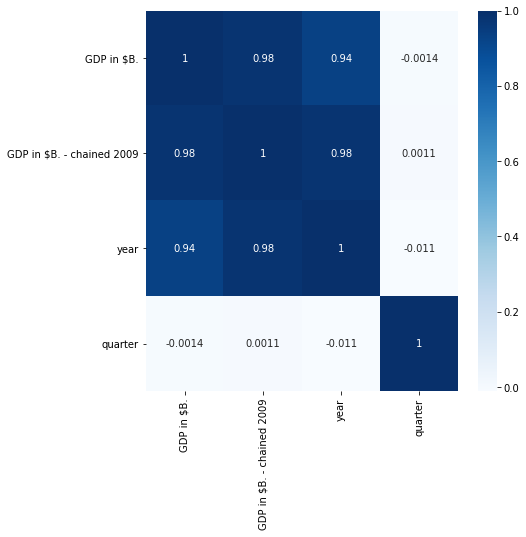

In [ ]:
# Heatmap to check correlation between variables 
plt.figure(figsize=(7, 7))
sns.heatmap(gdp_quaterly.corr(), annot=True, cmap="Blues")
plt.show()

In [ ]:
fig = px.line(gdp_quaterly, x="year", y="GDP in $B.", 
              color='quarter', 
              title='GDP in Billions of Dollar per year for each quarter', 
              width=1_000,
              labels={'values': 'Amount'})

fig.update_traces(mode='markers+lines')

fig.update_xaxes(title='Years')
fig.update_yaxes(title='Billions of dollar')

fig.show()

There is no significant difference between the quarters for each year.

In [ ]:
fig = px.line(gdp_quaterly, x="year", y="GDP in $B. - chained 2009", 
              color='quarter', 
              title='GDP in Billions of Dollar (chained 2009) per year for each quarter', 
              width=1_000,
              labels={'values': 'Amount'})

fig.update_traces(mode='markers+lines')

fig.update_xaxes(title='Years')
fig.update_yaxes(title='Billions of dollar')

fig.show()

Again, there is no significant difference between the quarters for each year.

In [ ]:
fig = px.histogram(gdp_quaterly, x="GDP in $B.", color='quarter',
                   marginal="box", # or violin, rug
                   width=1_200,
                   labels={'values': 'Amount'}, 
                   opacity=0.8)
fig.show()

In [ ]:
fig = px.histogram(gdp_quaterly, x="GDP in $B. - chained 2009", 
                   color='quarter',
                   marginal="box", # or violin, rug
                   width=1_200,
                   labels={'values': 'Amount'}, 
                   opacity=0.8)
fig.show()

In both histograms, the distribution for each quarter seems similar in the same year

#### 2.5 - Distribution type and data types

university_towns.txt

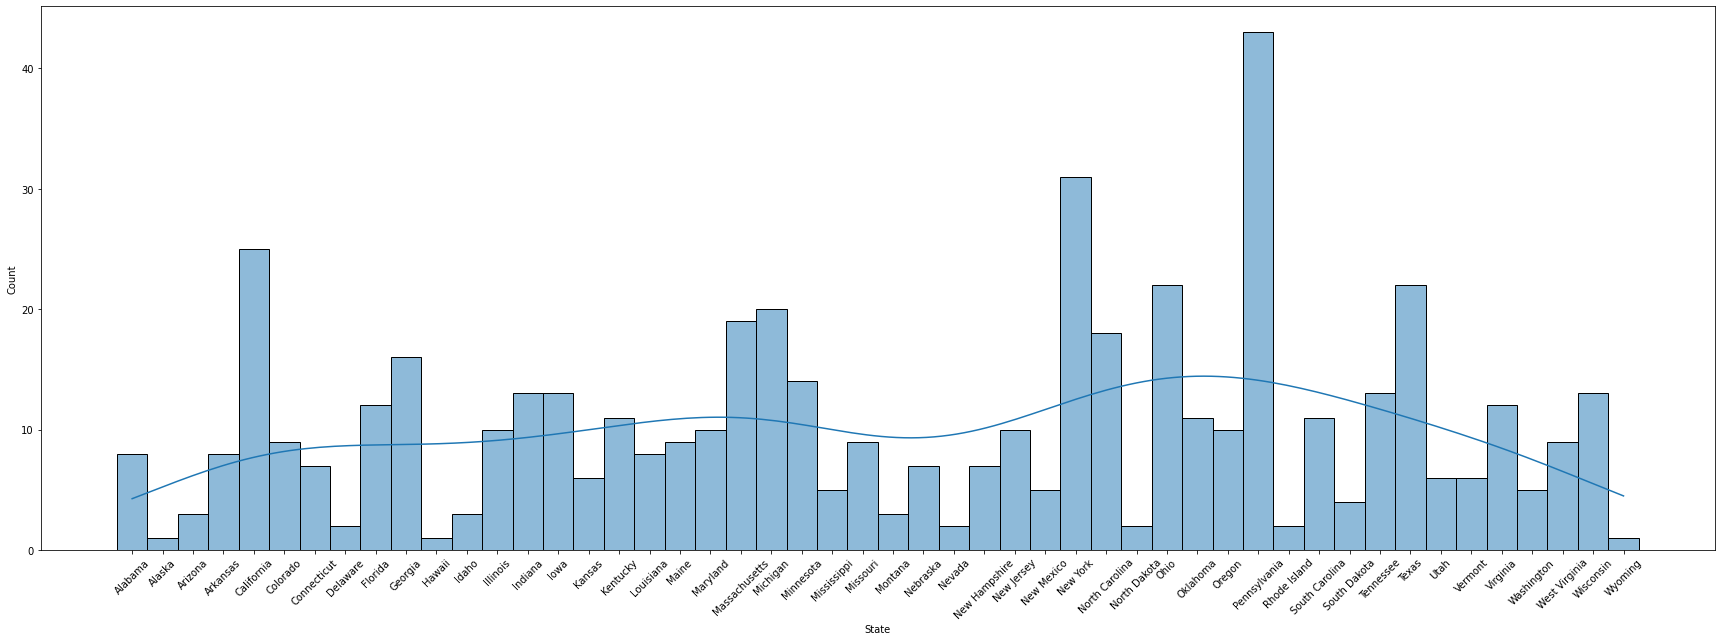

In [ ]:
plt.figure(figsize=(30, 10))
sns.histplot(data=universities, x="State", kde=True)
plt.xticks(rotation = 45)
plt.show()

In [ ]:
universities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   State       517 non-null    object
 1   University  517 non-null    object
 2   code        517 non-null    object
dtypes: object(3)
memory usage: 12.2+ KB


City_Zhvi_AllHomes.csv

In [ ]:
zillow_homes.head(3)

,RegionID,RegionName,State,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,...,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
0,6181,New York,NY,Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,472100,474300,477600,481400,485100,488800,492600,495900,499500,503500,506400,509900,515700,520800,522200,522400,523800,526200,528400,529600,530800,532200,533800,536200,540600,545600,551400,557200,563000,568700,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,12447,Los Angeles,CA,Los Angeles,2,155000.0,154600.0,154400.0,154200.0,154100.0,154300.0,154300.0,154200.0,154800.0,155900.0,157000.0,157700.0,158200.0,158600.0,158800.0,158900.0,159100.0,159800.0,160700.0,161900.0,163400.0,165400.0,167000.0,168500.0,169900.0,171400.0,172900.0,174300.0,175800.0,177800.0,180100.0,182600.0,184400.0,185600.0,186900.0,...,432700,440400,448100,455200,461900,467800,472300,475700,479400,484000,489400,494200,498100,501800,505600,509000,512600,516000,518900,521700,525100,528900,532400,535300,538200,541000,544000,547200,550600,554200,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
2,17426,Chicago,IL,Cook,3,109700.0,109400.0,109300.0,109300.0,109100.0,109000.0,109000.0,109600.0,110200.0,110800.0,111300.0,111700.0,112200.0,112300.0,112100.0,112200.0,113000.0,113700.0,114200.0,114800.0,115500.0,116200.0,117100.0,117600.0,117800.0,118300.0,119200.0,120000.0,120600.0,121500.0,122300.0,122700.0,122900.0,123300.0,123700.0,...,172400,175100,178200,181000,183200,184600,185800,187200,189100,191100,192500,192600,192400,192900,193900,195600,197800,200100,201700,202000,201200,200500,201500,204000,206500,207600,207700,208100,209100,209000,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000


In [ ]:
zillow_homes.groupby('State').count().head()

,RegionID,RegionName,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,...,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,14,14,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,7,7,7,7,7,7,7,7,...,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
AL,133,133,133,133,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93,95,95,95,95,95,95,97,97,97,97,97,97,97,97,97,97,97,97,98,98,...,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133
AR,76,76,76,76,74,74,74,74,74,74,74,74,74,74,75,75,75,75,75,75,75,75,75,75,75,75,76,76,76,76,76,76,76,76,76,76,76,76,76,76,...,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76,76
AZ,120,120,120,120,103,103,103,103,103,103,103,103,103,103,108,108,108,108,108,108,110,110,110,110,110,110,114,114,114,114,114,114,114,114,114,114,114,114,114,114,...,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
CA,700,700,700,700,601,601,601,601,601,601,601,601,601,601,628,628,628,628,628,628,630,630,630,630,630,630,641,641,613,459,459,641,642,642,655,663,663,663,663,663,...,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700,700


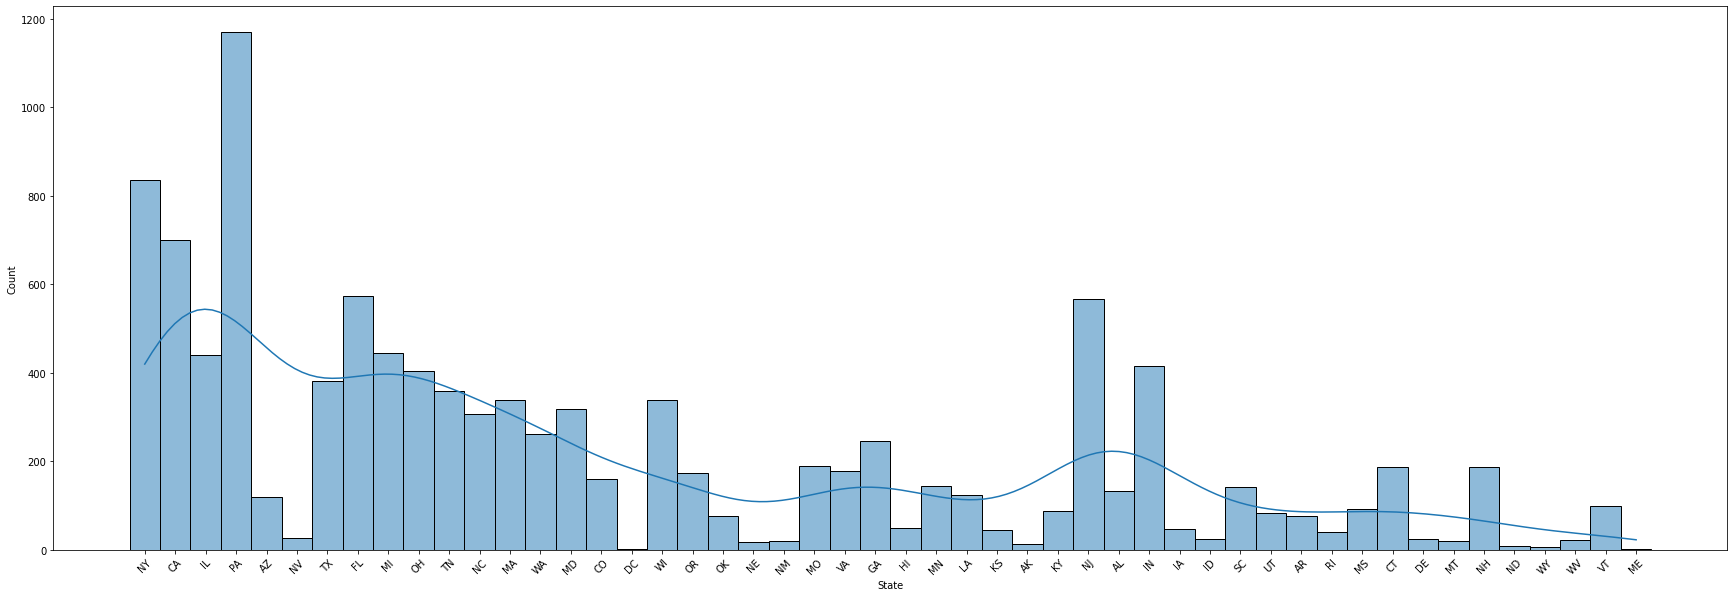

In [ ]:
plt.figure(figsize=(30, 10))
sns.histplot(data=zillow_homes, x="State", kde=True)
plt.xticks(rotation = 45)
plt.show()

In [ ]:
zillow_homes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10730 entries, 0 to 10729
Columns: 250 entries, RegionID to 2016-08
dtypes: float64(201), int64(46), object(3)
memory usage: 20.5+ MB


gdplev.xls

Annual

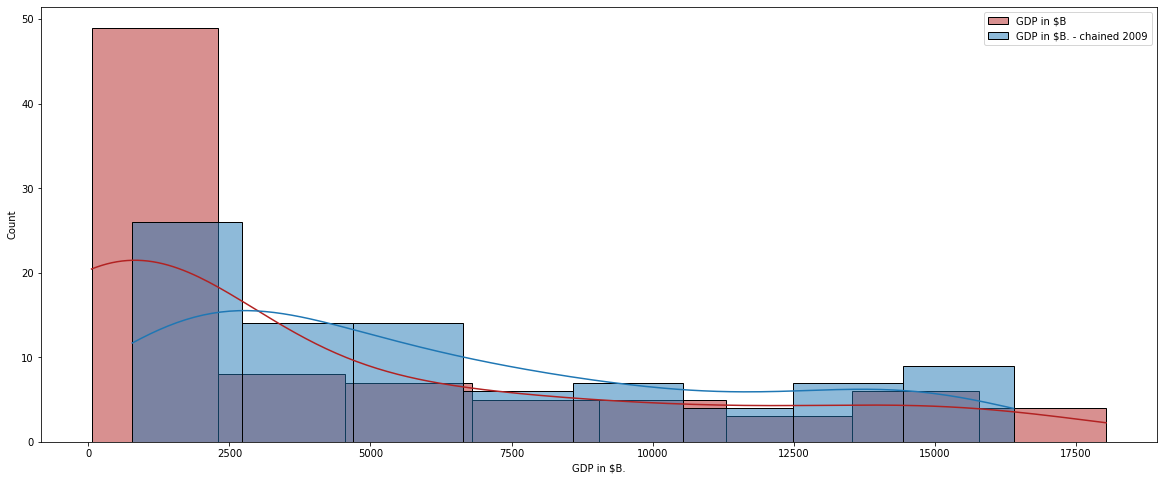

In [ ]:
plt.figure(figsize=(20, 8))
sns.histplot(data=gdp_annual, x="GDP in $B.", kde=True, color='firebrick', 
             label='GDP in $B')
sns.histplot(data=gdp_annual, x="GDP in $B. - chained 2009", kde=True,
             label='GDP in $B. - chained 2009')
plt.legend()
plt.show()

In [ ]:
gdp_annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       87 non-null     int64  
 1   GDP in $B.                 87 non-null     float64
 2   GDP in $B. - chained 2009  87 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 2.2 KB


Quaterly

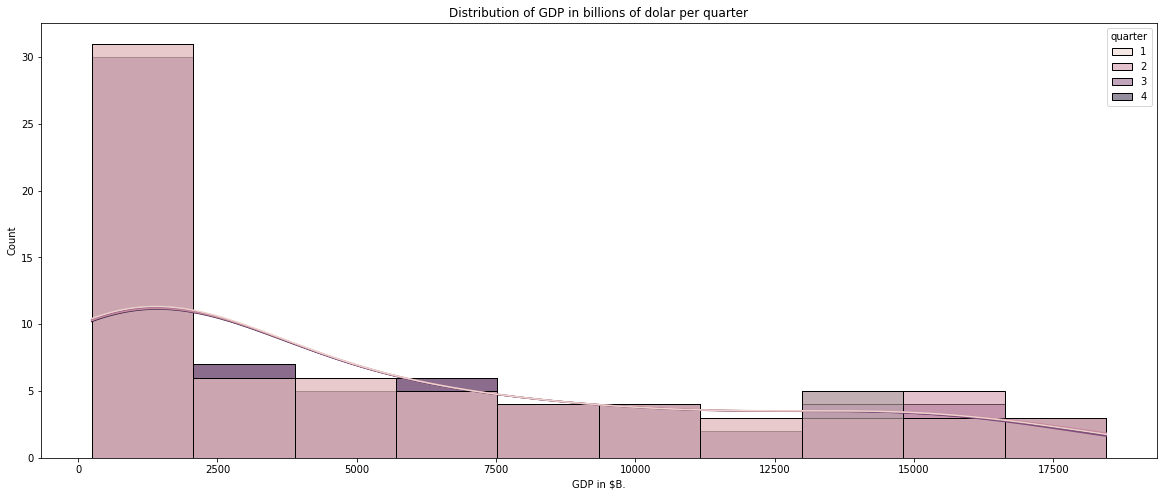

In [ ]:
plt.figure(figsize=(20, 8))
sns.histplot(data=gdp_quaterly, x="GDP in $B.", kde=True, 
             hue='quarter')
plt.title('Distribution of GDP in billions of dolar per quarter')
plt.show()

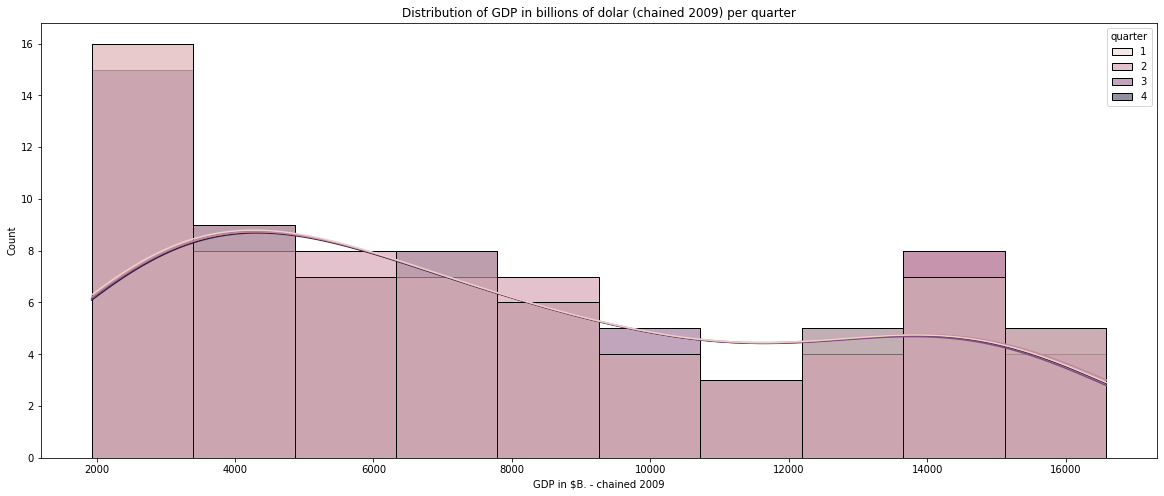

In [ ]:
plt.figure(figsize=(20, 8))
sns.histplot(data=gdp_quaterly, x="GDP in $B. - chained 2009", kde=True, 
             hue='quarter')
plt.title('Distribution of GDP in billions of dolar (chained 2009) per quarter')
plt.show()

In [ ]:
gdp_quaterly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   period                     278 non-null    object 
 1   GDP in $B.                 278 non-null    float64
 2   GDP in $B. - chained 2009  278 non-null    float64
 3   year                       278 non-null    int64  
 4   quarter                    278 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 11.0+ KB


### 2.6- Recessions

- A recession is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
- A recession bottom is the quarter within a recession which had the lowest GDP.

In [ ]:
gdp_quaterly.head(2)

,period,GDP in $B.,GDP in $B. - chained 2009,year,quarter
0,1947q1,243.1,1934.5,1947,1
1,1947q2,246.3,1932.3,1947,2


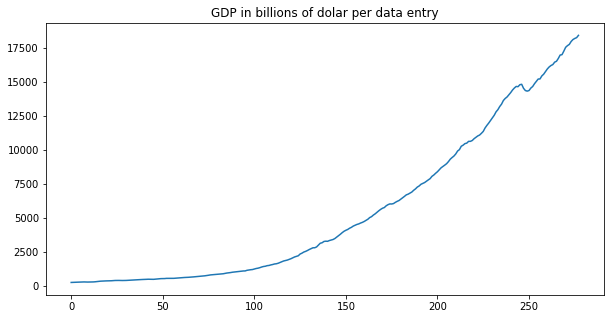

In [ ]:
plt.figure(figsize=(10, 5))
gdp_quaterly['GDP in $B.'].plot()
plt.title('GDP in billions of dolar per data entry')
plt.show()

In [ ]:
# Define a function to identify recessions
def recessions(data: pd.Series) -> list:
    data = list(data)
    results=[np.nan] # First data entry will never be in recession
    cnt_neg = 0
    cnt_pos = 0

    for i in range(1, len(data)):
        if data[i] < data[i-1]:
            cnt_neg += 1
            if cnt_neg >= 2:
                results.append(1)
                cnt_pos = 0
            else:
                results.append(np.nan)
        else:
            if cnt_neg >= 2:
                cnt_pos += 1
                if cnt_pos == 2:
                    cnt_neg = 0
                    cnt_pos = 0
                    results.append(1)
                else:
                    results.append(1)
            else:
                cnt_neg = 0
                results.append(np.nan)
    
    return results

In [ ]:
gdp_quaterly['recession'] = recessions(gdp_quaterly['GDP in $B.'])

# recession value in the same scale as GDP in $B
gdp_quaterly['recession scaled'] = gdp_quaterly['recession'] * gdp_quaterly['GDP in $B.']

In [ ]:
fig = px.line(gdp_quaterly, x="period", y='GDP in $B.', 
              title='Recessions', width=1_200,
              labels={'values': 'Amount'})


fig.add_scatter(x=gdp_quaterly['period'], 
                y=gdp_quaterly['recession scaled'], mode='lines',
                line_width=4,
                name='Recession')

fig.update_xaxes(title='Periods')
fig.update_yaxes(title='Billions of dollar')

fig.show()

In [ ]:
# Get the recessions periods (recessions_periods)
def get_recession_periods(values: pd.DataFrame, column_recession: str, 
                          column_period: str) -> list:
    results = []
    aux_results = []
    last_item_na = False

    for idx, item in enumerate(values[column_recession]):
        if not np.isnan(item):
            if last_item_na:
                if len(aux_results) > 0:
                    results.append(aux_results)
                aux_results = []
                aux_results.append(values[column_period][idx])
            else:
                aux_results.append(values[column_period][idx])

            last_item_na = False
        if np.isnan(item):
            last_item_na = True
    
    if len(aux_results) > 0:
        results.append(aux_results)

    return results

recession_periods = get_recession_periods(gdp_quaterly, 'recession', 'period')
recession_periods

[['1949q2', '1949q3', '1949q4', '1950q1', '1950q2'],
 ['1953q4', '1954q1', '1954q2', '1954q3'],
 ['1958q1', '1958q2', '1958q3'],
 ['2009q1', '2009q2', '2009q3', '2009q4']]

In [ ]:
# Find the recessions bottom
def recession_bottom(data: pd.DataFrame, col_periods: str, 
                     col_values: str, periods: list) -> tuple:
    
    bottom = data[data[col_periods] == periods[0]][col_values].values.tolist()[0]
    prd = periods[0]
    
    for period in periods:
        if bottom > data[data[col_periods] == period][col_values].values.tolist()[0]:
            bottom = data[data[col_periods] == period][col_values].values.tolist()[0]
            prd = period

    return (prd, bottom)

In [ ]:
# Period and value for recession bottom
bottoms = []
for recession in recession_periods:
    bottoms.append(recession_bottom(gdp_quaterly, 'period', 'GDP in $B.', recession))
bottoms

[('1949q4', 271.0), ('1954q1', 385.9), ('1958q1', 468.4), ('2009q2', 14340.4)]

In [ ]:
# Period and price for period before recession
pre_recession = []
for recession in recession_periods:
    idx = gdp_quaterly[gdp_quaterly['period'] == recession[0]].index[0] - 1 
    period_pre_recession = gdp_quaterly['period'][idx]

    pre_recession.append(period_pre_recession)

pre_recession

['1949q1', '1953q3', '1957q4', '2008q4']

In [ ]:
# Define a function to convert from quarter to aux
def quarter_to_month(values: list) -> list:
    months = []
    for value in values:
        aux = []
        if value[-2:] == 'q1':
            for i in range(1, 4):
                aux.append(value[:-2] + '-0' + str(i))
        elif value[-2:] == 'q2':
            for i in range(4, 7):
                aux.append(value[:-2] + '-0' + str(i))
        elif value[-2:] == 'q3':
            for i in range(7, 10):
                if i < 10:
                    aux.append(value[:-2] + '-0' + str(i))
                else:
                    aux.append(value[:-2] + '-' + str(i))
        elif value[-2:] == 'q4':
            for i in range(10, 13):
                aux.append(value[:-2] + '-' + str(i))
        
        months.append(aux)
                       
    return months

In [ ]:
bottoms

[('1949q4', 271.0), ('1954q1', 385.9), ('1958q1', 468.4), ('2009q2', 14340.4)]

In [ ]:
# Adjusting the values for pre_recession
pre_recession_months = quarter_to_month(pre_recession)

# Adjusting the values for recession bottoms
bottom_aux = []

for bottom in bottoms:
    bottom_aux.append(bottom[0])

bottom_months = quarter_to_month(bottom_aux)

print(bottom_months)
print(pre_recession_months)

[['1949-10', '1949-11', '1949-12'], ['1954-01', '1954-02', '1954-03'], ['1958-01', '1958-02', '1958-03'], ['2009-04', '2009-05', '2009-06']]
[['1949-01', '1949-02', '1949-03'], ['1953-07', '1953-08', '1953-09'], ['1957-10', '1957-11', '1957-12'], ['2008-10', '2008-11', '2008-12']]


The first zillow_homes entry is from 1996-04, so the only recession that will be evaluated is the one that started after April 1996.

In [ ]:
# Discard the values from before 1996-04
pre_recession_months = pre_recession_months[-1]
bottom_months = bottom_months[-1]

print(pre_recession_months)
print(bottom_months)

['2008-10', '2008-11', '2008-12']
['2009-04', '2009-05', '2009-06']


## 3 - T-Test

### 3.1 - Create a dataframe for the T-Test

In [ ]:
# Dataframe for the t-test
df_ttest = pd.DataFrame({'city': zillow_homes['RegionName']})

# Columns with data from pre_recession_months
for item in pre_recession_months:
    column = 'pre recession ' + item
    df_ttest[column] = zillow_homes[item]

# Columns with data from pre_recession_months
for item in bottom_months:
    column = 'bottom ' + item
    df_ttest[column] = zillow_homes[item]

df_ttest.head(3)

,city,pre recession 2008-10,pre recession 2008-11,pre recession 2008-12,bottom 2009-04,bottom 2009-05,bottom 2009-06
0,New York,491900.0,487500.0,484400.0,469700.0,466100.0,461700.0
1,Los Angeles,451200.0,443900.0,436800.0,417800.0,413700.0,410200.0
2,Chicago,229200.0,226700.0,225200.0,221900.0,219700.0,217500.0


In [ ]:
# Column with the mean value pre-recession
df_ttest['mean value pre-recession'] = df_ttest[['pre recession 2008-10', 'pre recession 2008-11', 'pre recession 2008-12']].mean(axis=1)

# Column with the mean value bottom
df_ttest['mean value bottom'] = df_ttest[['bottom 2009-04', 'bottom 2009-05', 'bottom 2009-06']].mean(axis=1)

df_ttest.head(3)

,city,pre recession 2008-10,pre recession 2008-11,pre recession 2008-12,bottom 2009-04,bottom 2009-05,bottom 2009-06,mean value pre-recession,mean value bottom
0,New York,491900.0,487500.0,484400.0,469700.0,466100.0,461700.0,487933.333333,465833.333333
1,Los Angeles,451200.0,443900.0,436800.0,417800.0,413700.0,410200.0,443966.666667,413900.000000
2,Chicago,229200.0,226700.0,225200.0,221900.0,219700.0,217500.0,227033.333333,219700.000000


In [ ]:
# Price ratio column -> price_ratio=quarter_before_recession/recession_bottom
df_ttest['price ratio'] = df_ttest['mean value pre-recession']/df_ttest['mean value bottom']
df_ttest.head(3)  

,city,pre recession 2008-10,pre recession 2008-11,pre recession 2008-12,bottom 2009-04,bottom 2009-05,bottom 2009-06,mean value pre-recession,mean value bottom,price ratio
0,New York,491900.0,487500.0,484400.0,469700.0,466100.0,461700.0,487933.333333,465833.333333,1.047442
1,Los Angeles,451200.0,443900.0,436800.0,417800.0,413700.0,410200.0,443966.666667,413900.000000,1.072642
2,Chicago,229200.0,226700.0,225200.0,221900.0,219700.0,217500.0,227033.333333,219700.000000,1.033379


In [ ]:
# Extract the city from the universities dataframe
universities['city'] = universities['University'].apply(lambda x: re.sub('(\(.*?\))', '', x).strip())
universities.head(3)

,State,University,code,city
0,Alabama,Auburn (Auburn University),AL,Auburn
1,Alabama,Florence (University of North Alabama),AL,Florence
2,Alabama,Jacksonville (Jacksonville State University),AL,Jacksonville


In [ ]:
# Add the information of university town in df_ttest dataframe
df_ttest['university town'] = df_ttest['city'].apply(lambda x: 1 if x in universities['city'].values.tolist() else 0)
df_ttest

,city,pre recession 2008-10,pre recession 2008-11,pre recession 2008-12,bottom 2009-04,bottom 2009-05,bottom 2009-06,mean value pre-recession,mean value bottom,price ratio,university town
0,New York,491900.0,487500.0,484400.0,469700.0,466100.0,461700.0,487933.333333,465833.333333,1.047442,0
1,Los Angeles,451200.0,443900.0,436800.0,417800.0,413700.0,410200.0,443966.666667,413900.000000,1.072642,0
2,Chicago,229200.0,226700.0,225200.0,221900.0,219700.0,217500.0,227033.333333,219700.000000,1.033379,0
3,Philadelphia,116300.0,115800.0,115500.0,116400.0,116100.0,116000.0,115866.666667,116166.666667,0.997418,0
4,Phoenix,186700.0,182800.0,180500.0,172100.0,168400.0,164200.0,183333.333333,168233.333333,1.089756,0
...,...,...,...,...,...,...,...,...,...,...,...
10725,Town of Wrightstown,149600.0,149800.0,148900.0,145100.0,144900.0,144500.0,149433.333333,144833.333333,1.031761,0
10726,Urbana,121500.0,122500.0,122900.0,121800.0,123200.0,125300.0,122300.000000,123433.333333,0.990818,0
10727,New Denmark,176700.0,177900.0,178200.0,177500.0,178600.0,180400.0,177600.000000,178833.333333,0.993103,0
10728,Angels,286100.0,280600.0,280300.0,286300.0,282800.0,279500.0,282333.333333,282866.666667,0.998115,0


In [ ]:
df_ttest[df_ttest['university town'] == 1].head(3)

,city,pre recession 2008-10,pre recession 2008-11,pre recession 2008-12,bottom 2009-04,bottom 2009-05,bottom 2009-06,mean value pre-recession,mean value bottom,price ratio,university town
5,Las Vegas,201500.0,194500.0,188800.0,170700.0,164500.0,157800.0,194933.333333,164333.333333,1.186207,1
6,San Diego,413100.0,407300.0,402500.0,390900.0,389000.0,388600.0,407633.333333,389500.000000,1.046555,1
7,Dallas,110700.0,109900.0,109100.0,106000.0,104700.0,104600.0,109900.000000,105100.000000,1.045671,1


### 3.2 - Prepare the dataframe for the T-Test

In [ ]:
# The missing values must be removed to run the t-test
# Check the missing values
df_ttest.isna().sum()

city                        0  
pre recession 2008-10       846
pre recession 2008-11       846
pre recession 2008-12       845
bottom 2009-04              812
bottom 2009-05              812
bottom 2009-06              800
mean value pre-recession    845
mean value bottom           800
price ratio                 845
university town             0  
dtype: int64

In [ ]:
# Drop the rows with missing values
df_ttest.dropna(inplace=True)

# Check the missing values
df_ttest.isna().sum().sum()

0

### 3.3 - Check the variability of the samples

For the t-test, ideally, both samples should have the same variance. 

In [ ]:
df_ttest.groupby('university town')['price ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
university town,,,,,,,,
0,9145.0,1.029771,0.059399,0.783173,0.999498,1.027421,1.055239,1.446920
1,739.0,1.023448,0.053309,0.748598,0.997619,1.021875,1.047083,1.352231


In this case, both samples contain similar standard deviation values (0.059 for non-university towns and 0.053 for university towns).

If the variances (or standard deviation) are not the same, the parameter equal_var in the ttest_ind function should be set as False.*texto em itálico*

### 3.4 - Check the variability of the samples

The T-Test assumes that the data is distributed normally

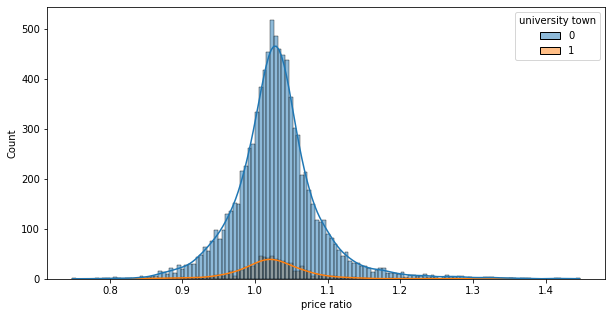

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_ttest, x="price ratio", kde=True, hue='university town')
plt.show()

Both datasets seem to be normally distributed.

### 3.5 - T-Test

T-Test hypoteses:

* H0: µ1 = µ2
* Ha: µ1 ≠ µ2

In [ ]:
# t-test
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
p = ttest_ind(df_ttest[df_ttest['university town'] == 1]['price ratio'], 
              df_ttest[df_ttest['university town'] == 0]['price ratio'])

p_value = p.pvalue
significance_level = 0.01

# p_value < alpha -> H0 can be rejected
if p_value < significance_level:
    print('The null hypotesis can be rejected, and we can assume the alternative hypoteses.')
    print('The mean values are statistically different from each other!')
else:
    print('It is not possible to reject the null hypothesis!')

The null hypotesis can be rejected, and we can assume the alternative hypoteses.
The mean values are statistically different from each other!


In [ ]:
p_value

0.00506171913005094

Result: The p-value is lower than the significance level and the null-hypotesis can be reject. 

It means the the two means are statistically different from each other and we can assume that they are from different populations.

In [ ]:
# price_ratio = quarter_before_recession/recession_bottom
mean_price_ratio_university = df_ttest[df_ttest['university town'] == 1]['price ratio'].mean()
mean_price_ratio_non_university = df_ttest[df_ttest['university town'] == 0]['price ratio'].mean()

print(f'University towns mean price ratio: {round(mean_price_ratio_university, 4)}')
print(f'Non-university towns mean price ratio: {round(mean_price_ratio_non_university, 4)}\n')


if abs(mean_price_ratio_university - 1) > abs(mean_price_ratio_non_university - 1):
    print('The mean price ratio for university towns is closer to 1 than the mean price ratio of non-university towns.')
else:
    print('The mean price ratio for non-university towns is closer to 1 than the mean price ratio of university towns.')

print('It indicates that the variation considering the value before and during the recession is smaller in this group than in the other.')

University towns mean price ratio: 1.0234
Non-university towns mean price ratio: 1.0298

The mean price ratio for non-university towns is closer to 1 than the mean price ratio of university towns.
It indicates that the variation considering the value before and during the recession is smaller in this group than in the other.
